# Examples of different flow speeds in the tails

We take some simple examples to show that in the tails the choice of kinetic energy affects the speed of the flow, and argue that the tuning is more robust to the entire sample space when the tail kinetic energy is chosen so that the drift is $O(|x|)$.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# specific functions
import HMC as h
from k_energies import *

## Simple Gaussian flow

First we demonstrate the flow_verb function with a simple example.

In [2]:
x0 = 10.0
p0 = 1.0
U = Gauss() # set potential and kinetic energy families
K_g = Gauss()

samples = h.flow_verb(x0, p0, U.grad, K_g.grad, L = 100, e = 0.1)
print samples[0,0:5]

[ 10.          10.05         9.9995       9.849005     9.60001995]


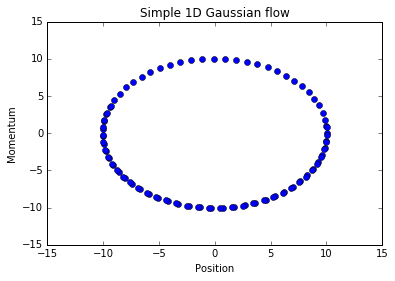

In [3]:
plt.plot(samples[0,:],samples[1,:],'bo')
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.title('Simple 1D Gaussian flow');

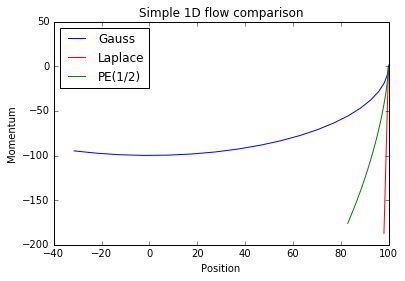

In [4]:
x0 = 100
K_lap = Laplace()
K_pe = PE_family(1.5)
s_gauss = h.flow_verb(x0, p0, U.grad, K_g.grad, L = 20,e = 0.1)
s_lap = h.flow_verb(x0, p0, U.grad, K_lap.grad, L = 20,e = 0.1)
s_pe = h.flow_verb(x0, p0, U.grad, K_pe.grad, L = 20,e = 0.1)

plt.plot(s_gauss[0,:],s_gauss[1,:],'b-',label='Gauss')
plt.plot(s_lap[0,:],s_lap[1,:],'r-',label='Laplace')
plt.plot(s_pe[0,:],s_pe[1,:],'g-',label='PE(1/2)')
plt.xlabel('Position')
plt.ylabel('Momentum')
plt.title('Simple 1D flow comparison')
plt.legend(loc=2);

We can see from the above that the speed of the flow on phase space is much faster when the kinetic energy is chosen such that $\nabla K \circ \nabla U(x) = x$.  In the case where the potential is quadratic, meaning the target is Gaussian, then this means that the choice of a Gaussian kinetic energy is optimal in this sense.

## 2D Gaussian flow $x$-marginal

Now we examine the $x$-marginal flow in the tails of a correlated 2D Gaussian distribution (so considering the space we really care about and how the flow behaves on this), with associated potential

\begin{equation*}
U(x) = \frac{x_1^2 - 2\rho x_1 x_2 + x_2^2}{2(1-\rho^2)}
\end{equation*}

The corresponsing gradient vector is

\begin{equation*}
\nabla U(x) = \frac{1}{1-\rho^2} \left( \begin{array}{cc} x_1 - \rho x_2 \\ x_2 - \rho x_1 \end{array} \right)
\end{equation*}

In [5]:
# Create potential class for correlated Gaussian
class CorrGauss:
    """2D Gaussian with correlation"""
    def __init__(self, rho):
        self.rho = rho
        
    def value(self, x):
        rho = self.rho
        z = x[0]**2 - 2.0*rho*x[0]*x[1] + x[1]**2
        return z / (2.0*(1-rho**2))
    
    def grad(self, x):
        rho = self.rho
        return np.array([x[0] - rho*x[1], x[1] - rho*x[0]]) / (1-rho**2)

rho = 0.9
U = CorrGauss(rho)
print U.value([100,100])

5263.15789474


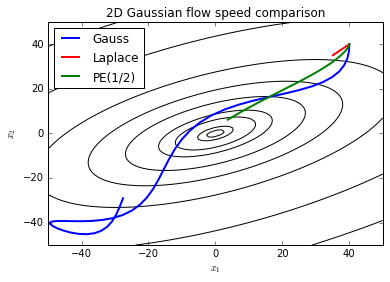

In [6]:
# plot simple contour
plt.figure()  # Create a new figure window
xlist = np.linspace(-50.0, 50.0, 100)
ylist = np.linspace(-50.0, 50.0, 100) # Create 1-D arrays for x,y dimensions
X,Y = np.meshgrid(xlist, ylist) # Create 2-D grid xlist,ylist values

Z = X**2 - 2.0*rho*X*Y + Y**2 / (2.0*(1-rho**2)) # Compute function values on the grid

plt.contour(X, Y, Z, [5, 20, 100, 200, 500, 1000, 2000, 5000, 10000], colors = 'k'); # contour plot

# plot flow trajectory on x-space
x0 = np.array([40,40])
p0 = np.array([0,-30])
lfs = 50


s_corr_gauss = h.flow_verb(x0, p0, U.grad, K_g.grad, L = lfs,e = 0.1)
s_corr_lap = h.flow_verb(x0, p0, U.grad, K_lap.grad, L = lfs,e = 0.1)
s_corr_pe = h.flow_verb(x0, p0, U.grad, K_pe.grad, L = lfs,e = 0.1)
plt.plot(s_corr_gauss[0,:],s_corr_gauss[1,:], 'b', linewidth = 2, label = "Gauss");
plt.plot(s_corr_lap[0,:],s_corr_lap[1,:], 'r-', linewidth = 2, label = "Laplace");
plt.plot(s_corr_pe[0,:],s_corr_pe[1,:], 'g-', linewidth = 2, label = "PE(1/2)");
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2D Gaussian flow speed comparison')
plt.legend(loc=2);

## Check out arrow or quiver functions to insert arrows.

The two-dimensional correlated Gaussian example shows a similar story.  We can see that the Gaussian choice of kinetic energy covers position space much more quickly than the other two choices, whilst maintaining stability (unlike any choice with lighter tails).  Note that the heavier tailed kinetic energies dampen osciallations caused by the injected noise, since the Taylor expansion of $\nabla K \circ \nabla U(p - h x)$ here gives

\begin{equation*}
\nabla K (p - h \nabla U(x)) = \nabla K (-h\nabla U(x)) + \nabla^2 K (-h \nabla U(x))p + \nabla^3 K(-h \nabla U(x))p^2/2 + ...
\end{equation*}

If $K(p)$ grows less than quadratically (i.e. heavier than Gaussian tails), then $\nabla^2 K$ and subsequent terms in the series will become very small as $\nabla U(x)$ grows, meaning that the oscillations induced by $p$ are negated and the direction of the flow is more targetted to the middle of the space.

We show next that if the tails of the potential are changed then a different optimal choice of kinetic energy is required to maintain this balance.

## A lighter/heavier-tailed 2D example: Power Exponential with $\beta = 3/2$ and $\beta = 3$.

This example is similar to the previous in that we consider a 2D model which exhibits correlation, but this time the tails are variable.  The centred unit scale multivariate power exponential family has associated potential (up to additive constants) given by

\begin{equation*}
U(x) = \frac{1}{2}\left( x^T\Sigma^{-1} x \right)^{\beta/2}
\end{equation*}

Here we choose $\Sigma_{11} = \Sigma_{22} = 1$ and $\Sigma_{12} = \Sigma_{21} = \rho$. The resulting potential can be simplified to take the form

\begin{equation*}
U(x) = \frac{1}{2}\left( \frac{x_1^2 - 2\rho x_1 x_2 + x_2^2}{1-\rho^2} \right)^{\beta/2}
\end{equation*}

and with corresponding gradient vector

\begin{equation*}
\nabla U(x) = \frac{\beta}{2(1-\rho^2)} \left( \frac{x_1^2 - 2\rho x_1 x_2 + x_2^2}{1-\rho^2} \right)^{\beta/2 - 1} \times \left( \begin{array}{c} x_1 - \rho x_2 \\ x_2 - \rho x_1 \end{array} \right)
\end{equation*}

In [7]:
# Create potential class for correlated PE(\beta) density?
class CorrPE:
    """2D Power Exponential with correlation"""
    def __init__(self, rho, beta):
        self.rho = rho
        self.beta = beta
        
    def value(self, x):
        rho = self.rho
        beta = self.beta
        z = x[0]**2 - 2.0*rho*x[0]*x[1] + x[1]**2
        return (1/2.0) * ( z / (1-rho**2) )**(beta / 2.0)
    
    def grad(self, x):
        rho = self.rho
        beta = self.beta
        z = x[0]**2 - 2.0*rho*x[0]*x[1] + x[1]**2
        vec = np.array([x[0] - rho*x[1], x[1] - rho*x[0]]) / (1-rho**2)
        return (beta / 2.0)* ( z / (1-rho**2) )**(beta / 2.0 - 1) * vec

rho = 0.9
beta_heavy = 1.5
beta_light = 3
U_heavy = CorrPE(rho, beta_heavy)
U_light = CorrPE(rho, beta_light)
print [U_heavy.value([100,100]), U_light.value([100,100])]
print np.vstack([U_heavy.grad([100,100]),U_light.grad([100,100])])

[519.609760474439, 539988.6063606077]
[[  3.89707320e+00   3.89707320e+00]
 [  8.09982910e+03   8.09982910e+03]]


### Lighter tails - Gaussian KE is not stable

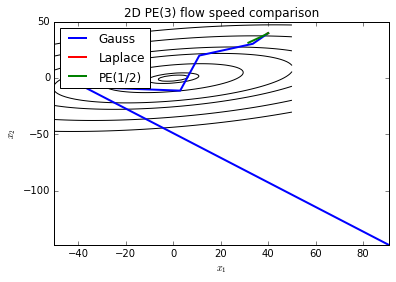

In [8]:
# plot simple contour
xlist = np.linspace(-50.0, 50.0, 100)
ylist = np.linspace(-50.0, 50.0, 100) # Create 1-D arrays for x,y dimensions
X,Y = np.meshgrid(xlist, ylist) # Create 2-D grid xlist,ylist values

Z_temp = X**2 - 2.0*rho*X*Y + Y**2 / (1-rho**2) # Compute function values on the grid
Z = Z_temp**(beta_light / 2.0) / 2.0

plt.contour(X, Y, Z, [100, 500, 10000, 50000, 100000, 250000, 500000], colors = 'k'); # contour plot (SORT OUT)

# plot flow trajectory on x-space
x0 = np.array([40,40])
p0 = np.array([0,-30])
lfs = 6


s_corr_gauss = h.flow_verb(x0, p0, U_light.grad, K_g.grad, L = lfs,e = 0.1)
s_corr_lap = h.flow_verb(x0, p0, U_light.grad, K_lap.grad, L = lfs,e = 0.1)
s_corr_pe = h.flow_verb(x0, p0, U_light.grad, K_pe.grad, L = lfs,e = 0.1)
plt.plot(s_corr_gauss[0,:],s_corr_gauss[1,:], 'b', linewidth = 2, label = "Gauss");
plt.plot(s_corr_lap[0,:],s_corr_lap[1,:], 'r-', linewidth = 2, label = "Laplace");
plt.plot(s_corr_pe[0,:],s_corr_pe[1,:], 'g-', linewidth = 2, label = "PE(1/2)");
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2D PE(3) flow speed comparison')
plt.legend(loc=2);

The Gaussian choice produces unstable numerical flows, which diverge after a few steps of the numerical integrator.  Actually in this case PE(1.5) is optimal.  We choose several lower values of $\beta$ to show this.

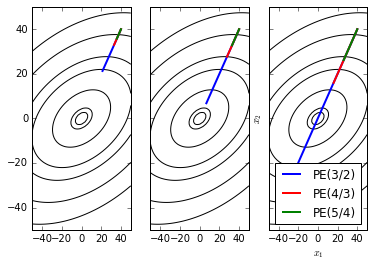

In [9]:
# define extra kinetic energies (we will also use Laplacian).
K_half = PE_family(3 / 2.0)
K_third = PE_family(4/3.0)
K_quar = PE_family(5 / 4.0)


x0 = np.array([40,40])
p0 = np.array([0,-10])

# generate samples and plots
e = 0.1

lfs = 10
s_corr_half = h.flow_verb(x0, p0, U_light.grad, K_half.grad, L = lfs,e = e)
s_corr_third = h.flow_verb(x0, p0, U_light.grad, K_third.grad, L = lfs,e = e)
s_corr_quar = h.flow_verb(x0, p0, U_light.grad, K_quar.grad, L = lfs,e = e)

# generate subplots
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)

# subplot 1
ax1.contour(X, Y, Z, [100, 500, 10000, 50000, 100000, 250000, 500000], colors = 'k');
ax1.plot(s_corr_half[0,:],s_corr_half[1,:], 'b', linewidth = 2, label = "PE(3/2)");
ax1.plot(s_corr_third[0,:],s_corr_third[1,:], 'r-', linewidth = 2, label = "PE(4/3)");
ax1.plot(s_corr_quar[0,:],s_corr_quar[1,:], 'g-', linewidth = 2, label = "PE(5/4)");

plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

# subplot 2
lfs = 15
s_corr_half = h.flow_verb(x0, p0, U_light.grad, K_half.grad, L = lfs,e = e)
s_corr_third = h.flow_verb(x0, p0, U_light.grad, K_third.grad, L = lfs,e = e)
s_corr_quar = h.flow_verb(x0, p0, U_light.grad, K_quar.grad, L = lfs,e = e)

ax2.contour(X, Y, Z, [100, 500, 10000, 50000, 100000, 250000, 500000], colors = 'k');
ax2.plot(s_corr_half[0,:],s_corr_half[1,:], 'b', linewidth = 2, label = "PE(3/2)");
ax2.plot(s_corr_third[0,:],s_corr_third[1,:], 'r-', linewidth = 2, label = "PE(4/3)");
ax2.plot(s_corr_quar[0,:],s_corr_quar[1,:], 'g-', linewidth = 2, label = "PE(5/4)");

plt.xlabel('$x_1$');

# subplot 3
lfs = 25
s_corr_half = h.flow_verb(x0, p0, U_light.grad, K_half.grad, L = lfs,e = e)
s_corr_third = h.flow_verb(x0, p0, U_light.grad, K_third.grad, L = lfs,e = e)
s_corr_quar = h.flow_verb(x0, p0, U_light.grad, K_quar.grad, L = lfs,e = e)

ax3.contour(X, Y, Z, [100, 500, 10000, 50000, 100000, 250000, 500000], colors = 'k');
ax3.plot(s_corr_half[0,:],s_corr_half[1,:], 'b', linewidth = 2, label = "PE(3/2)");
ax3.plot(s_corr_third[0,:],s_corr_third[1,:], 'r-', linewidth = 2, label = "PE(4/3)");
ax3.plot(s_corr_quar[0,:],s_corr_quar[1,:], 'g-', linewidth = 2, label = "PE(5/4)");

plt.xlabel('$x_1$');
plt.legend(loc = 3);

# INSERT figure out how to add an overall title and independent x-axes for these plots.

### Heavier tails: light tailed kinetic energy can speed up exploration

Now we can do the same thing for the heavier-tailed version.  Here it should be that a kinetic energy with lighter than Gaussian tails is the optimum choice.

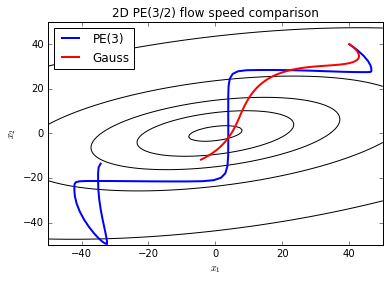

In [10]:
# generate samples and plots for PE(1/2) example

K_three = PE_family(3)
K_gauss = Gauss()

lfs = 70
e = 0.1

x0 = np.array([40,40])
p0 = np.array([5,-5])

s_corr_three = h.flow_verb(x0, p0, U_heavy.grad, K_three.grad, L = lfs, e = e)
s_corr_gauss = h.flow_verb(x0, p0, U_heavy.grad, K_gauss.grad, L = lfs, e = e)

# compute contour values
Z = Z_temp**(beta_heavy / 2.0) / 2.0
plt.contour(X, Y, Z, [10, 50, 100, 200, 500, 1000], colors = 'k'); # contour plot (SORT OUT)
plt.plot(s_corr_three[0,:],s_corr_three[1,:], 'b', linewidth = 2, label = "PE(3)");
plt.plot(s_corr_gauss[0,:],s_corr_gauss[1,:], 'r-', linewidth = 2, label = "Gauss");

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('2D PE(3/2) flow speed comparison')
plt.legend(loc=2);

As can be seen, the PE(3) choice of kinetic energy is numerically stable, but allows faster exploration of the target distribution than a Gaussian choice of kinetic energy. INSERT maybe test out the sampling here?

## Slowing down funnels

We should be able to slow down some forms of funnel like behaviour using the more robust choice of kineti energy, hower to completely slow down Neal's funnel we may have to use Laplacian tails.  The analogy with MALTA should be mentioned in the paper for this purpose.

We first consider the Funnel-like institution designed to mimic the features of Normal inverse Gamma distributions, which has accompanying potential

\begin{equation*}
U(x) = x_1^2 + x_2^2 + x_1^2 x_2^2,
\end{equation*}

and corresponding gradient vector

\begin{equation*}
\nabla U (x) = 2 \left( \begin{array}{cc} x_1 ( 1+x_2^2) \\ x_2 (1+x_1^2) \end{array} \right).
\end{equation*}

We can see that the gradient blows up at a faster than linear rate in $\|x\|$.

In [11]:
# Roberts & Tweedie funnel
class Funnel:
    """2D Roberts & Tweedie Funnel"""        
    def value(self, x):
        return x[0]**2 + x[1]**2 + x[0]**2 * x[1]**2
    
    def grad(self, x):
        return np.array([2*x[0]*(1+x[1]**2), 2*x[1]*(1+x[0]**2)])

U_f = Funnel()
x_test = [100,1]
print U_f.value(x_test)
print U_f.grad(x_test)

20001
[  400 20002]


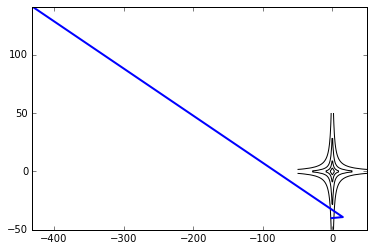

In [12]:
# Create contour plot and add trajectories with various choices of KE, PE(4/3) should stabilise flow.
Z = X**2 + Y**2 + X**2 * Y**2
plt.contour(X, Y, Z, [10, 100, 1000, 10000], colors = 'k');

K_gauss = Gauss()
K_third = PE_family(4 / 3.0)

# generate samples
x0 = np.array([-1,-40])
p0 = np.array([1,1])

e = 0.1
s_corr_gauss = h.flow_verb(x0, p0, U_f.grad, K_gauss.grad, L = 3, e = e)
s_corr_third = h.flow_verb(x0, p0, U_f.grad, K_third.grad, L = 100, e = e)

# add to plot
plt.plot(s_corr_gauss[0,:],s_corr_gauss[1,:], 'b', linewidth = 2, label = "Gauss");


# Consider another section with Neal's funnel...this has a steeper form of KE.

We can see that the Gaussian choice of kinetic energy again produces unstable numerics, diverging after just a few leapfrog steps.  In this case the flow can be stabilised with the choice PE(4/3), which gives the below trajectory after 100 leapfrog steps.

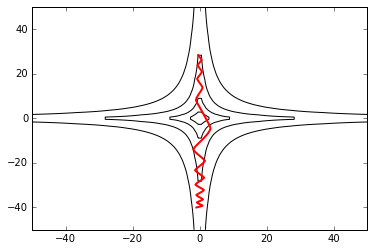

In [13]:
plt.contour(X, Y, Z, [10, 100, 1000, 10000], colors = 'k');
plt.plot(s_corr_third[0,:],s_corr_third[1,:], 'r-', linewidth = 2, label = "PE(4/3)");

Acceptance rate: 0.000200
LF Steps: 100, Step-size: 0.300
Numerical divergences: 4973


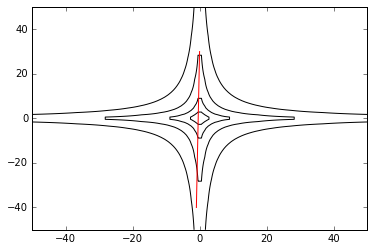

In [14]:
# Once the sampler finds the centre it stays
samples = h.HMC(5000, np.array([-1,-40]), U_f, K_third, L = 100, e = 0.3)
x_samples = samples['x']

plt.contour(X, Y, Z, [10, 100, 1000, 10000], colors = 'k');
plt.plot(x_samples[0,:],x_samples[1,:], 'r-');

NB: What we need to check here is the probability of being above a potential value of 10, and whether this is less than 1 in 5000, to confirm whether the sampler should be exploring more of the tails or not.

## Robust tuning in the tails vs. the centre of the space

This can be a simple large dimensional iid example, where time to get to the centre is non-negligible, and we can show that tuning during the transient phase and equilibrium phase are comparable (i.e. the tuning based on one will work reasonably in the other, which won't be true of e.g. Laplacian tuning.

Acceptance rate: 1.000000
LF Steps: 10, Step-size: 0.130
Numerical divergences: 0
Acceptance rate: 1.000000
LF Steps: 10, Step-size: 0.300
Numerical divergences: 0
Acceptance rate: 0.900000
LF Steps: 10, Step-size: 0.400
Numerical divergences: 0


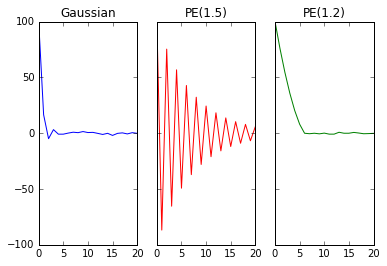

In [15]:
# Choose a simple potential but large dimensional example: robust regression?  Consider example from PE paper?
U_robust = PE_family(3)
K_robust = PE_family(1.5)
K_rob2 = PE_family(1.2)
K_gauss = Gauss()

# start sampler in the tails and make sure it takes a long time to reach the centre

# Begin with starting value 100, dimension 2 (can increase as necessary)
x0 = 100 * np.ones(2)
n_samples = 20

samples_gauss = h.HMC(n_samples, x0, U_robust, K_gauss, L = 10, e = 0.13)
samples_robust = h.HMC(n_samples, x0, U_robust, K_robust, L = 10, e = 0.3)
samples_rob2 = h.HMC(n_samples, x0, U_robust, K_rob2, L = 10, e = 0.4)
x_samples_gauss = samples_gauss['x']
x_samples_robust = samples_robust['x']
x_samples_rob2 = samples_rob2['x']

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)

ax1.set_title('Gaussian')
ax1.plot(x_samples_gauss[0,:], 'b-');

ax2.set_title('PE(1.5)')
ax2.plot(x_samples_robust[0,:], 'r-');

ax3.set_title('PE(1.2)')
ax3.plot(x_samples_rob2[0,:], 'g-');

Here we have a light-tailed example, started from reasonably far into the tails, with each choice of kinetic energy tuned to give reasonable results.

k_energies.py:75: RuntimeWarning: overflow encountered in square
  return np.absolute(p)**(b-1) * np.sign(p)
HMC.py:30: RuntimeWarning: invalid value encountered in subtract
  p = p - e * dU(x) / 2.0


Acceptance rate: 0.000000
LF Steps: 10, Step-size: 0.130
Numerical divergences: 0
Acceptance rate: 1.000000
LF Steps: 10, Step-size: 0.300
Numerical divergences: 0
Acceptance rate: 1.000000
LF Steps: 10, Step-size: 0.400
Numerical divergences: 0


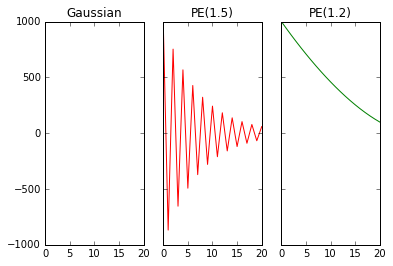

In [16]:
# Now try the same tuning but with a different starting point (further in tha tails)
x0 = 1000 * np.ones(2)
n_samples = 20

samples_gauss = h.HMC(n_samples, x0, U_robust, K_gauss, L = 10, e = 0.13)
samples_robust = h.HMC(n_samples, x0, U_robust, K_robust, L = 10, e = 0.3)
samples_rob2 = h.HMC(n_samples, x0, U_robust, K_rob2, L = 10, e = 0.4)
x_samples_gauss = samples_gauss['x']
x_samples_robust = samples_robust['x']
x_samples_rob2 = samples_rob2['x']

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)

ax1.set_title('Gaussian')
ax1.plot(x_samples_gauss[0,:], 'b-');

ax2.set_title('PE(1.5)')
ax2.plot(x_samples_robust[0,:], 'r-');

ax3.set_title('PE(1.2)')
ax3.plot(x_samples_rob2[0,:], 'g-');

Starting the same samplers with the same choices of step-size in the tails means that the Gaussian option doesn't move.  For the other two, the choices still seem reasonable.

Acceptance rate: 1.000000
LF Steps: 10, Step-size: 0.130
Numerical divergences: 0
Acceptance rate: 0.950000
LF Steps: 10, Step-size: 0.300
Numerical divergences: 0
Acceptance rate: 0.950000
LF Steps: 10, Step-size: 0.400
Numerical divergences: 0


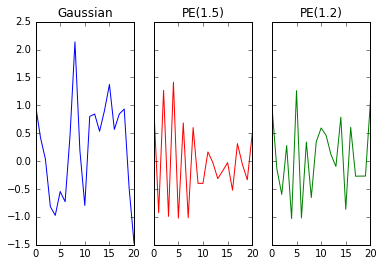

In [17]:
# Now start from the centre and see if the same tuning is suitable
x0 = 1 * np.ones(2)
n_samples = 20

samples_gauss = h.HMC(n_samples, x0, U_robust, K_gauss, L = 10, e = 0.13)
samples_robust = h.HMC(n_samples, x0, U_robust, K_robust, L = 10, e = 0.3)
samples_rob2 = h.HMC(n_samples, x0, U_robust, K_rob2, L = 10, e = 0.4)
x_samples_gauss = samples_gauss['x']
x_samples_robust = samples_robust['x']
x_samples_rob2 = samples_rob2['x']

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)

ax1.set_title('Gaussian')
ax1.plot(x_samples_gauss[0,:], 'b-');

ax2.set_title('PE(1.5)')
ax2.plot(x_samples_robust[0,:], 'r-');

ax3.set_title('PE(1.2)')
ax3.plot(x_samples_rob2[0,:], 'g-');

Starting with the same step-sizes in the centre of the space, we now see that the choice in the Gaussian case is too small, whereas in both other cases the choices still seem reasonable.

NB: I would have thought that the heavier-tailed choice PE(1.2) would be more affected than it is, so perhaps further experiments are needed for this.

## The negligible moves property

We test this on a simple Gaussian example.

Acceptance rate: 0.701000
LF Steps: 1, Step-size: 1.900
Numerical divergences: 0
Acceptance rate: 0.675000
LF Steps: 1, Step-size: 1.900
Numerical divergences: 0
Acceptance rate: 0.695000
LF Steps: 1, Step-size: 1.900
Numerical divergences: 0


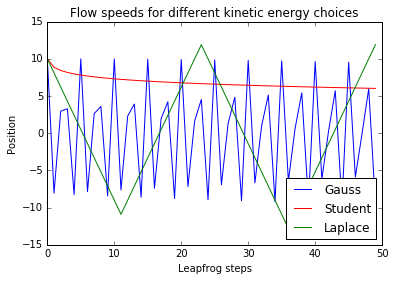

In [45]:
U = Gauss()
K_t = Student(5)
K_g = Gauss()
K_l = Laplace()

n_samples = 1000
x_start = 0

neg_t = h.HMC(n_samples, x_start, U, K_t, L = 1, e = 1.9)
neg_l = h.HMC(n_samples, x_start, U, K_t, L = 1, e = 1.9)
neg_g = h.HMC(n_samples, x_start, U, K_t, L = 1, e = 1.9)

samples_t = neg_t['x']
samples_l = neg_l['x']
samples_g = neg_g['x']

#plt.plot(samples[0,:]);
Leapfrog = 50
x0 = 10
p0 = 0

test_t = h.flow_verb(x0, p0, U.grad, K_t.grad, L = Leapfrog, e = 1.9)
test_g = h.flow_verb(x0, p0, U.grad, K_g.grad, L = Leapfrog, e = 1.9)
test_l = h.flow_verb(x0, p0, U.grad, K_l.grad, L = Leapfrog, e = 1.9)

plt.plot(test_g[0,:],'b-', label = "Gauss")
plt.plot(test_t[0,:],'r-', label = "Student")
plt.plot(test_l[0,:],'g-', label = "Laplace")
plt.xlabel('Leapfrog steps')
plt.ylabel('Position')
plt.legend(loc="lower right")
plt.title('Flow speeds for different kinetic energy choices');